# LiDAR Exploration and Grape Classification with laspy and OpenCV using Mahalanobis Distance

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import laspy

## Introduction

This notebook demonstrates an attempt at an end-to-end workflow for isolating candidate grape clusters in vineyard LiDAR data using a combination of RGB filtering and statistical classification. Utilizing the open-source python packages laspy, OpenCV and numpy, this approach builds on established methods in grape yield estimation and adapts them by incorporating a Mahalanobis distance-based filter for cluster identification. A key component of this approach is the use of Mahalanobis distance—a statistical measure that calculates how far each LiDAR point’s color is from a reference grape color model by considering the variance and correlations in the data. This distance metric is beneficial for identifying candidate grape clusters because it theoretically allows us to flag points that are statistically similar to our reference, thereby aiding in yield estimation. The following sections provide a step-by-step explanation of the process. From constructing a reference grape color model to classifying LiDAR points, visualizing the results, and saving the new LiDAR file for further manipulation.

## Code

Below is code that loads five images taken from a larger photo of the grapevine. Each image is a small snapshot of the riesling grapes found on the grapevine in order to extract the RGB values from them. They are converted from BGR to RGB and then to HSV, resized each image to the smallest common dimensions, and finally stacked them into a single numpy array for use later.

In [2]:
img = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape1.jpg')
img2 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape2.jpg')
img3 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape3.jpg')
img4 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape4.jpg')
img5 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape5.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4_rgb = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5_rgb = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
img2_hsv = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2HSV)
img3_hsv = cv2.cvtColor(img3_rgb, cv2.COLOR_RGB2HSV)
img4_hsv = cv2.cvtColor(img4_rgb, cv2.COLOR_RGB2HSV)
img5_hsv = cv2.cvtColor(img5_rgb, cv2.COLOR_RGB2HSV)

shapes = [img_hsv.shape, img2_hsv.shape, img3_hsv.shape, img4_hsv.shape, img5_hsv.shape]
target_h = min(shape[0] for shape in shapes)
target_w = min(shape[1] for shape in shapes)

img_hsv_resized = cv2.resize(img_hsv, (target_w, target_h))
img2_hsv_resized = cv2.resize(img2_hsv, (target_w, target_h))
img3_hsv_resized = cv2.resize(img3_hsv, (target_w, target_h))
img4_hsv_resized = cv2.resize(img4_hsv, (target_w, target_h))
img5_hsv_resized = cv2.resize(img5_hsv, (target_w, target_h))

img_stack = np.stack([img_hsv_resized, img2_hsv_resized, img3_hsv_resized, img4_hsv_resized, img5_hsv_resized], axis=0)

Below reads four wood images taken from the same grapevine photo, but specifically on the wood posts and branches. They are converted to RGB and then HSV, resized to the smallest common dimensions among the images, and finally stacked into a single numpy array for use later as well.

In [3]:
wood1 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood1.jpg')
wood2 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood2.jpg')
wood3 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood3.jpg')
wood4 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood4.jpg')

wood1_rgb = cv2.cvtColor(wood1, cv2.COLOR_BGR2RGB)
wood2_rgb = cv2.cvtColor(wood2, cv2.COLOR_BGR2RGB)
wood3_rgb = cv2.cvtColor(wood3, cv2.COLOR_BGR2RGB)
wood4_rgb = cv2.cvtColor(wood4, cv2.COLOR_BGR2RGB)

wood1_hsv = cv2.cvtColor(wood1_rgb, cv2.COLOR_RGB2HSV)
wood2_hsv = cv2.cvtColor(wood2_rgb, cv2.COLOR_RGB2HSV)
wood3_hsv = cv2.cvtColor(wood3_rgb, cv2.COLOR_RGB2HSV)
wood4_hsv = cv2.cvtColor(wood4_rgb, cv2.COLOR_RGB2HSV)

shapes = [wood1_hsv.shape, wood2_hsv.shape, wood3_hsv.shape, wood4_hsv.shape]
target_h = min(shape[0] for shape in shapes)
target_w = min(shape[1] for shape in shapes)

wood1_hsv_resized = cv2.resize(wood1_hsv, (target_w, target_h))
wood2_hsv_resized = cv2.resize(wood2_hsv, (target_w, target_h))
wood3_hsv_resized = cv2.resize(wood3_hsv, (target_w, target_h))
wood4_hsv_resized = cv2.resize(wood4_hsv, (target_w, target_h))

wood_stack = np.stack([wood1_hsv_resized, wood2_hsv_resized, wood3_hsv_resized, wood4_hsv_resized], axis=0)

In [4]:
grape_colors = img_stack.reshape((-1, 3))

In [5]:
wood_colors = wood_stack.reshape((-1, 3))

Below is code that computes the mean and covariance matrix for the grape and wood color arrays (treating columns as variables), and then calculates the inverse covariance matrices for each set. The mean and covariance for each of these arrays are the key values used to compute the Mahalanbois distances later.

In [6]:
mu = np.mean(grape_colors, axis=0)
cov = np.cov(grape_colors, rowvar=False)

print(mu)
print(cov)

[ 28.46802721 216.03809524 144.20272109]
[[ 1.74948760e+00  2.83648092e+00 -6.52465697e-01]
 [ 2.83648092e+00  6.28457363e+02 -4.38434549e+02]
 [-6.52465697e-01 -4.38434549e+02  8.13811837e+02]]


In [7]:
mu_wood = np.mean(wood_colors, axis=0)
cov_wood = np.cov(wood_colors, rowvar=False)

print(mu_wood)
print(cov_wood)

[ 41.28763441  70.2437276  119.99910394]
[[3767.37279763 -598.85581754  492.64241043]
 [-598.85581754  772.05534179 -895.09933298]
 [ 492.64241043 -895.09933298 1526.93363148]]


In [8]:
inv_cov = np.linalg.inv(cov)

In [9]:
inv_cov_wood = np.linalg.inv(cov_wood)

Read LiDAR data from a LAS file that contains a single row of the grapevine in question. Extracts the red, green, and blue channels from the grapevine row into an RGB array. It then computes the Mahalanobis distances of each LiDAR color sample from both the grape and wood color sample distributions using their respective mean vectors and inverse covariance matrices.

In [10]:
# change to location of row LiDAR data directory
las = laspy.read('../CodyKresta8_8_24_riesling_low1_ref_Row_3.las')

In [11]:
r = las.red
g = las.green
b = las.blue

In [12]:
lidar_rgb = np.column_stack((r, g, b))

In [13]:
diff = lidar_rgb - mu
d2 = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
mahal_distances = np.sqrt(d2)

In [14]:
diff_wood = lidar_rgb - mu_wood
d2_wood = np.einsum('ij,jk,ik->i', diff_wood, inv_cov_wood, diff_wood)
mahal_distances_wood = np.sqrt(d2_wood)

Below calculates descriptive statistics (minimum, maximum, mean, median, standard deviation, 25th and 75th percentiles) for the Mahalanobis distances computed from both the grape and wood datasets and prints them.

In [15]:
min_val = np.min(mahal_distances)
max_val = np.max(mahal_distances)
mean_val = np.mean(mahal_distances)
median_val = np.median(mahal_distances)
std_val = np.std(mahal_distances)

p25 = np.percentile(mahal_distances, 25)
p75 = np.percentile(mahal_distances, 75)

print("Mahalanobis Distance Statistics:")
print("Min:", min_val)
print("Max:", max_val)
print("Mean:", mean_val)
print("Median:", median_val)
print("Standard Deviation:", std_val)
print("25th Percentile:", p25)
print("75th Percentile:", p75)

Mahalanobis Distance Statistics:
Min: 5402.881836827666
Max: 49433.78309663788
Mean: 19627.37918883207
Median: 18190.78212228766
Standard Deviation: 6396.579526202613
25th Percentile: 14899.782741880754
75th Percentile: 22843.789419292138


In [16]:
min_val_wood = np.min(mahal_distances_wood)
max_val_wood = np.max(mahal_distances_wood)
mean_val_wood = np.mean(mahal_distances_wood)
median_val_wood = np.median(mahal_distances_wood)
std_val_wood = np.std(mahal_distances_wood)

p25_wood = np.percentile(mahal_distances_wood, 25)
p75_wood = np.percentile(mahal_distances_wood, 75)

print("Mahalanobis Distance Statistics:")
print("Min:", min_val_wood)
print("Max:", max_val_wood)
print("Mean:", mean_val_wood)
print("Median:", median_val_wood)
print("Standard Deviation:", std_val_wood)
print("25th Percentile:", p25_wood)
print("75th Percentile:", p75_wood)

Mahalanobis Distance Statistics:
Min: 461.2558704924867
Max: 7443.04737930331
Mean: 2721.6976489924664
Median: 2493.165626984515
Standard Deviation: 946.0628024787949
25th Percentile: 2049.0275435581225
75th Percentile: 3157.3216450071786


Below generates two histograms—one for the grape Mahalanobis distances and one for the wood Mahalanobis distances—with overlays for the mean (red dashed line) and median (green dashed line) to visually represent the distribution of distances.

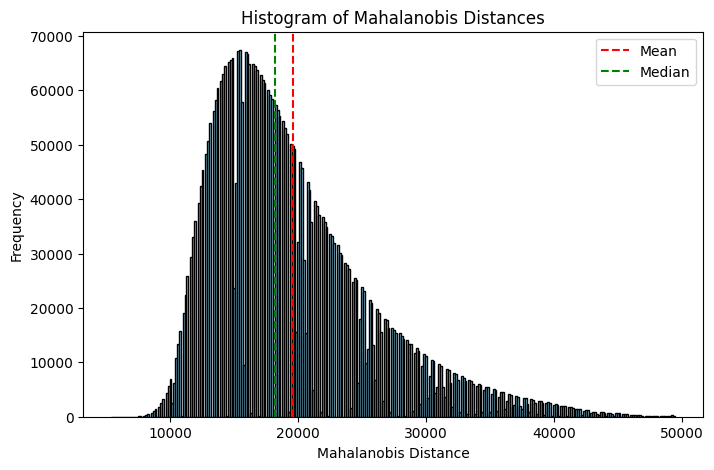

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(mahal_distances, bins=300, color='skyblue', edgecolor='black')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Mahalanobis Distances")
plt.axvline(x=mean_val, color='red', linestyle='--', label='Mean')
plt.axvline(x=median_val, color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

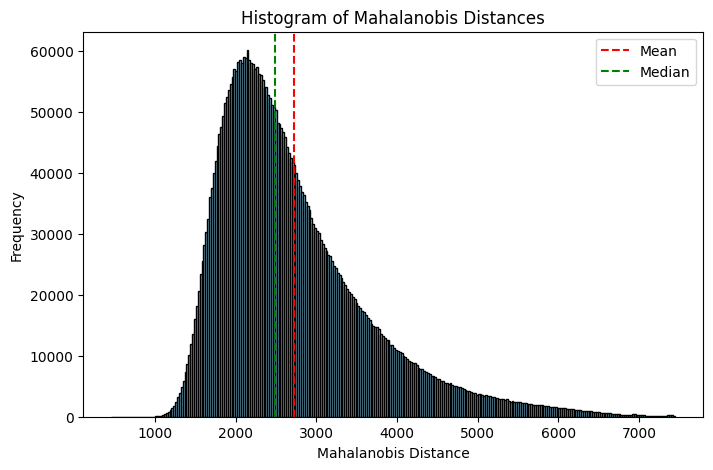

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(mahal_distances_wood, bins=300, color='skyblue', edgecolor='black')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Mahalanobis Distances")
plt.axvline(x=mean_val_wood, color='red', linestyle='--', label='Mean')
plt.axvline(x=median_val_wood, color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

Finally, this code applies a threshold to the Mahalanobis distances to classify LiDAR points as grape points. Points with distances below the threshold are flagged in the LAS file's classification array, the number of such points is printed, and the updated LAS file is saved to be used to test the results against the original LAS file we imported earlier.

In [19]:
threshold = 10000
grape_points_mask = mahal_distances <= threshold
grape_points_rgb = lidar_rgb[grape_points_mask]
print("Number of LiDAR points classified as grapes:", grape_points_rgb.shape[0])

Number of LiDAR points classified as grapes: 22046


In [20]:
las.classification[grape_points_mask] = 1
num_grape_points = np.count_nonzero(las.classification == 1)
print("Number of points classified as grapes:", num_grape_points)

Number of points classified as grapes: 22046


In [21]:
las.write('CodyKresta8_8_24_riesling_low1_ref_Row_3_classified.las')

## Conclusion

In conclusion, this notebook presents a complete workflow for isolating potential grape clusters from vineyard LiDAR data by combining RGB filtering with statistical classification. The process involves creating reference color models, processing images with OpenCV, and classifying LiDAR points based on their Mahalanobis distance from these models. Although the code successfully produces histograms and an updated LAS file, it currently relies on an arbitrary threshold for classification. Since the Mahalanobis distance distributions are unimodal and skewed right, there isn’t a clear-cut point that accurately separates grape points from non-grape points. This limitation underscores the need for further calibration and refinement before the method can be reliably used for yield estimation.